Automatically created module for IPython interactive environment
media de los datos : 339.8226647472809
(12,) <class 'numpy.ndarray'>
GPML kernel: 51.5**2 * RBF(length_scale=54.8) + 2.61**2 * RBF(length_scale=109) * ExpSineSquared(length_scale=1.46, periodicity=1) + 0.608**2 * RationalQuadratic(alpha=0.737, length_scale=1.07) + 0.187**2 * RBF(length_scale=0.12) + WhiteKernel(noise_level=0.0364)
Log-marginal-likelihood: -114.426

Learned kernel: 51.5**2 * RBF(length_scale=54.8) + 2.61**2 * RBF(length_scale=109) * ExpSineSquared(length_scale=1.46, periodicity=1) + 0.608**2 * RationalQuadratic(alpha=0.737, length_scale=1.07) + 0.187**2 * RBF(length_scale=0.12) + WhiteKernel(noise_level=0.0364)
Log-marginal-likelihood: -114.426


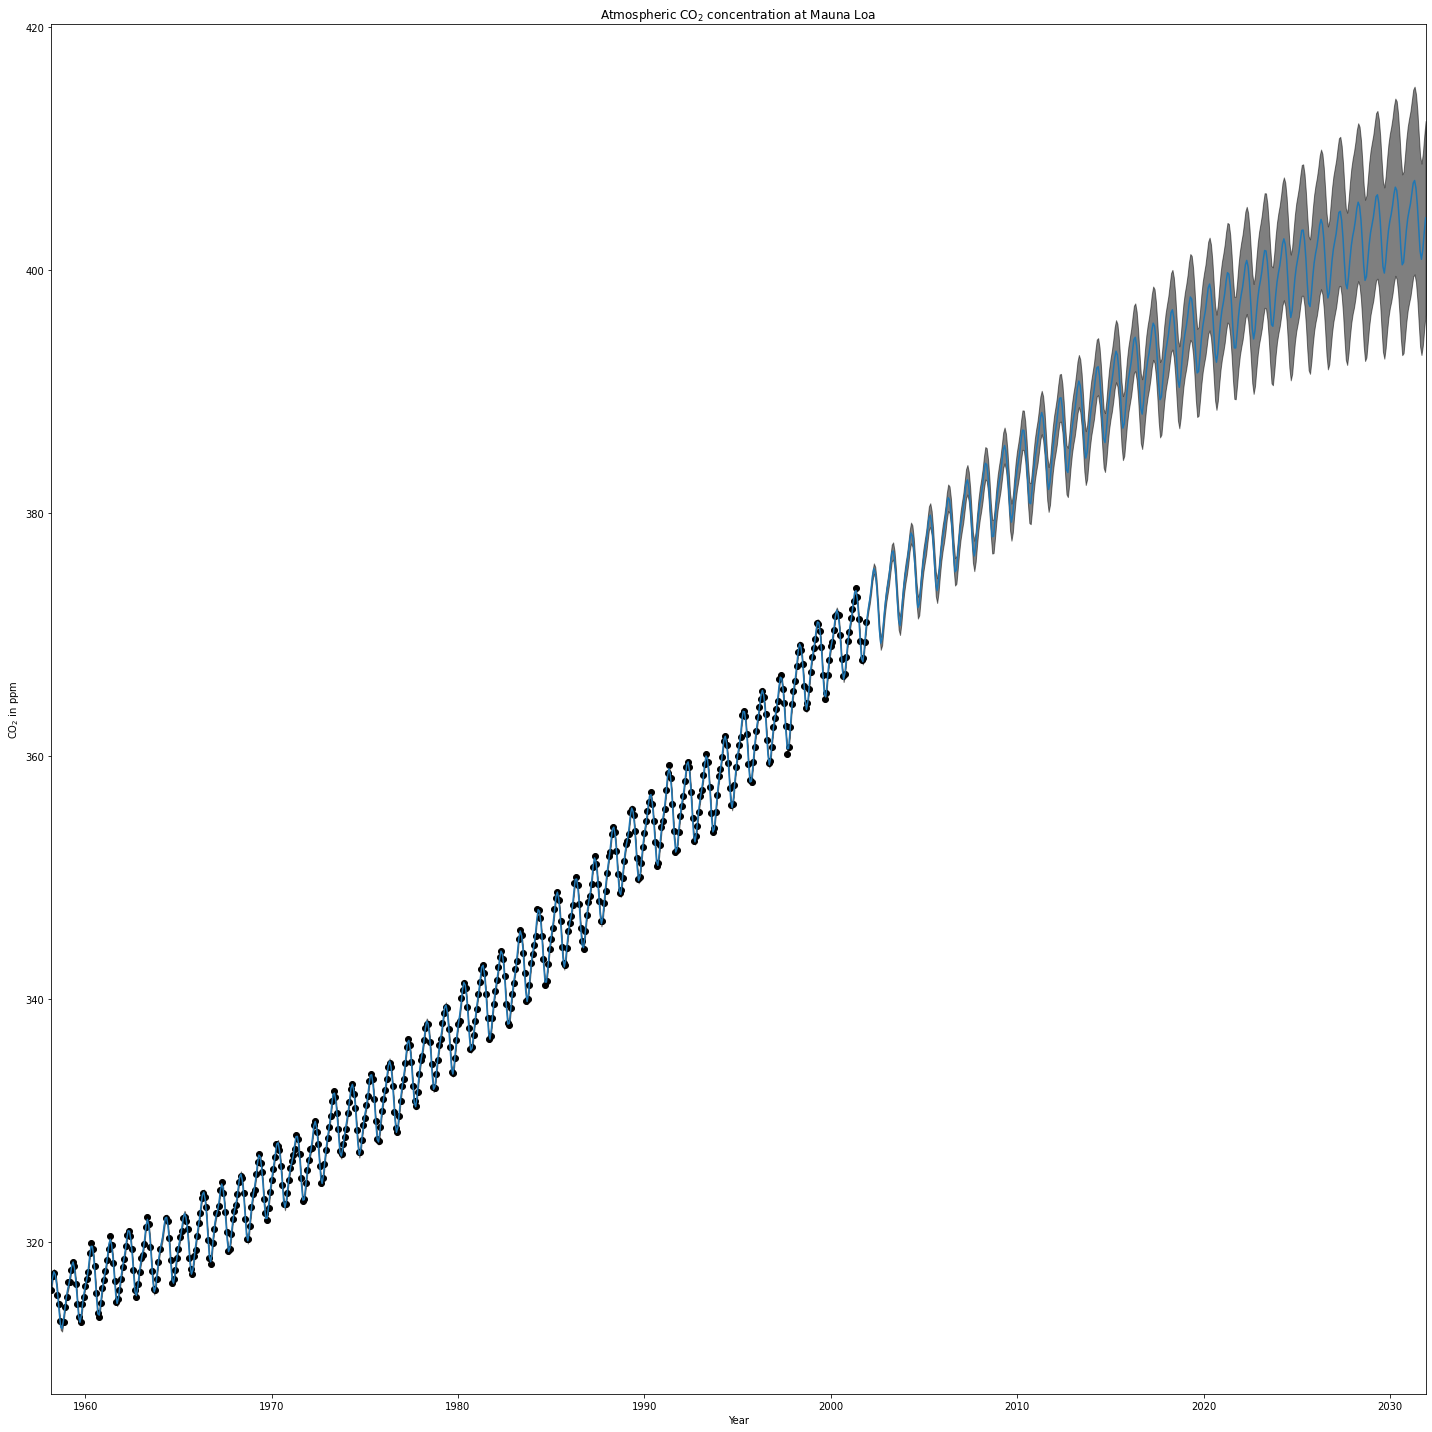

In [29]:
# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause


import numpy as np

from scipy.optimize import minimize
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, ConstantKernel

print(__doc__)

def jacobiano(x, func):
    x = np.array(x)
    resultados =func(theta=x,eval_gradient=True)
    print("resultados jacobiano :",resultados[:])
    return resultados[1]


def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data[:, 0]
    m = ml_data.data[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1, 1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs


X, y = load_mauna_loa_atmospheric_co2()

media_y = np.sum(y)/len(y)
y = y - media_y
print("media de los datos :", media_y)



inHiper = np.array([34.4,41.8,3.267,180.,1.44,1.,0.446,17.7,0.957,0.197,0.138,0.0336])
#inHiper =  np.array([66**2. ,67.* ,2.4**2  ,90. ,1.3 ,1.,0.66**2 ,1.2 ,0.78 ,0.18**2 ,0.14  ,0.19]) # Libro de rasmusen


#inHiper = inHiper + 0.06*inHiper*np.random.randn(len(inHiper))

# Kernel with parameters given in GPML book
k1 = ConstantKernel(inHiper[0])*RBF(length_scale=inHiper[1])  # long term smooth rising trend
k2 = ConstantKernel(inHiper[2])*RBF(length_scale=inHiper[3]) \
    * ExpSineSquared(length_scale=inHiper[4], periodicity=inHiper[5])  # seasonal component
# medium term irregularity
k3 = ConstantKernel(inHiper[6])*RationalQuadratic(length_scale=inHiper[7], alpha=inHiper[8])
k4 = ConstantKernel(inHiper[9])*RBF(length_scale=inHiper[10]) + WhiteKernel(noise_level=inHiper[11])  # noise terms
kernel_gpml = k1 + k2 + k3 + k4

gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer="fmin_l_bfgs_b", normalize_y=True,n_restarts_optimizer=5)

#gp = GaussianProcessRegressor(kernel=kernel_gpml,optimizer=None, normalize_y=True)

gp.fit(X, y)


#inHiper = [10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1,10e-1]
print(np.shape(inHiper),type(inHiper))
#print("mira aqui ",gp.log_marginal_likelihood(inHiper,eval_gradient=True))

#res = minimize(gp.log_marginal_likelihood,inHiper,args=gp.log_marginal_likelihood, method='Newton-CG', jac=jacobiano)


print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))
print("\nLearned kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

print("============")

X_ = np.linspace(X.min(), X.max() + 30, 1000)[:, np.newaxis]
y_pred, y_std = gp.predict(X_, return_std=True)

y_pred = y_pred + media_y
y = y + media_y

# Illustration
plt.figure(figsize=(20,20))

plt.scatter(X, y, c='k')
plt.plot(X_, y_pred)
plt.fill_between(X_[:, 0], y_pred - y_std, y_pred + y_std,
                 alpha=0.5, color='k')
plt.xlim(X_.min(), X_.max())
plt.xlabel("Year")
plt.ylabel(r"CO$_2$ in ppm")
plt.title(r"Atmospheric CO$_2$ concentration at Mauna Loa")
plt.tight_layout()
plt.show()